In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

path = "/content/gdrive/My Drive"
os.chdir(path)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.models import load_model

from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping,LearningRateScheduler

import keras.backend as K


IMG_W = 224 #定义裁剪的图片宽度
IMG_H = 224 #定义裁剪的图片高度
CLASS = 4 #图片的分类数
EPOCHS = 80 #迭代周期
BATCH_SIZE = 64 #批次大小
TRAIN_PATH = 'gpr_data/train' #训练集存放路径
TEST_PATH = 'gpr_data/val' #测试集存放路径
SAVE_PATH = 'gpr_lr.h5' #模型保存路径
LOG_PATH = 'gpr_log/gpr_lr'
LEARNING_RATE = 1e-5 #学习率
DROPOUT_RATE = 0.2 #抗拟合，不工作的神经网络百分比


def scheduler(epoch):
    # 每隔20个epoch，学习率减小为原来的1/10
    if epoch % 20 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 10)
        print("lr changed to {}".format(lr * 10))
    return K.get_value(model.optimizer.lr)


tensorboard = TensorBoard(log_dir=LOG_PATH,write_images=True,write_graph=True)
checkpoint = ModelCheckpoint(filepath=SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learning_rate_scheduler = LearningRateScheduler(scheduler)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


train_datagen = ImageDataGenerator(
    # rotation_range = 40,     # 随机旋转度数
    width_shift_range = 0.2, # 随机水平平移
    height_shift_range = 0.2,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    # shear_range = 20,       # 随机错切变换
    zoom_range = 0.2,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    fill_mode = 'nearest',   # 填充方式
)
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
)

model = Sequential() #创建一个神经网络对象

#添加一个卷积层，传入固定宽高单通道的图片，以32种不同的卷积核构建32张特征图，
# 卷积核大小为3*3，构建特征图比例和原图相同，激活函数为relu函数。
model.add(Conv2D(input_shape=(IMG_W,IMG_H,1),filters=32,kernel_size=3,padding='same',activation='relu'))
#再次构建一个卷积层
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
#构建一个池化层，提取特征，池化层的池化窗口为2*2，步长为2。
model.add(MaxPool2D(pool_size=2,strides=2))
#继续构建卷积层和池化层，区别是卷积核数量为64。
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
#继续构建卷积层和池化层，区别是卷积核数量为128。
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten()) #数据扁平化
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu')) #构建一个具有128个神经元的全连接层
model.add(Dense(64,activation='relu')) #构建一个具有64个神经元的全连接层
model.add(Dropout(DROPOUT_RATE)) #加入dropout，防止过拟合。
model.add(Dense(CLASS,activation='softmax')) #输出层，一共14个神经元，对应14个分类

adam = Adam(lr=LEARNING_RATE) #创建Adam优化器

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) #使用交叉熵代价函数，adam优化器优化模型，并提取准确率

train_generator = train_datagen.flow_from_directory( #设置训练集迭代器
    TRAIN_PATH, #训练集存放路径
    target_size=(IMG_W,IMG_H), #训练集图片尺寸
    color_mode='grayscale',
    batch_size=BATCH_SIZE #训练集批次
    )

test_generator = test_datagen.flow_from_directory( #设置测试集迭代器
    TEST_PATH, #测试集存放路径
    target_size=(IMG_W,IMG_H), #测试集图片尺寸
    color_mode='grayscale',
    batch_size=BATCH_SIZE, #测试集批次
    )

print(train_generator.class_indices) #打印迭代器分类

try:
    model = load_model('{}'.format(SAVE_PATH))  #尝试读取训练好的模型，再次训练
    print('模型加载成功，继续训练中......')
except:
    print('未找到模型，正在开始训练......') #如果没有训练过的模型，则从头开始训练

history = model.fit_generator( #模型拟合
                    train_generator,  #训练集迭代器
                    steps_per_epoch=len(train_generator), #每个周期需要迭代多少步（图片总量/批次大小=11200/64=175）
                    epochs=EPOCHS, #迭代周期
                    validation_data=test_generator, #测试集迭代器
                    validation_steps=len(test_generator), #测试集迭代多少步
                    shuffle=True,
                    # callbacks=[tensorboard, checkpoint, early_stopping]
                    callbacks=[tensorboard,checkpoint,learning_rate_scheduler]
                    )

#model.save('{}.h5'.format(SAVE_PATH)) #保存模型
print('finish {} epochs!'.format(EPOCHS))

Found 1200 images belonging to 4 classes.
Found 312 images belonging to 4 classes.
{'coal': 0, 'free_space': 1, 'pec': 2, 'soil': 3}
未找到模型，正在开始训练......
Epoch 1/80
19/19 [==============================] - 58s 3s/step - loss: 1.3865 - acc: 0.2371 - val_loss: 1.3858 - val_acc: 0.2500

Epoch 00001: val_loss improved from inf to 1.38576, saving model to gpr_lr3.h5
Epoch 2/80
19/19 [==============================] - 48s 3s/step - loss: 1.3857 - acc: 0.2769 - val_loss: 1.3848 - val_acc: 0.3654

Epoch 00002: val_loss improved from 1.38576 to 1.38479, saving model to gpr_lr3.h5
Epoch 3/80
19/19 [==============================] - 51s 3s/step - loss: 1.3853 - acc: 0.2862 - val_loss: 1.3830 - val_acc: 0.3718

Epoch 00003: val_loss improved from 1.38479 to 1.38298, saving model to gpr_lr3.h5
Epoch 4/80
19/19 [==============================] - 51s 3s/step - loss: 1.3825 - acc: 0.3312 - val_loss: 1.3808 - val_acc: 0.2500

Epoch 00004: val_loss improved from 1.38298 to 1.38078, saving model to gpr_lr3

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

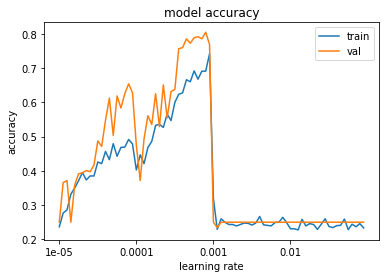

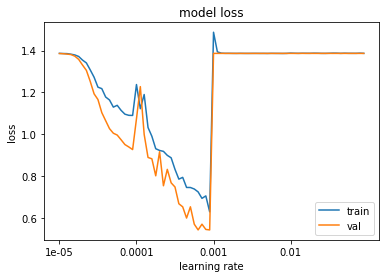

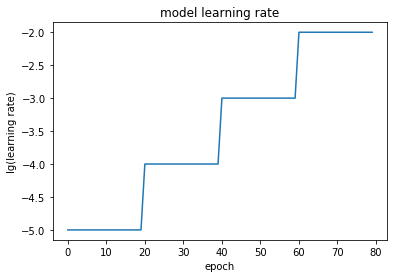

In [0]:
import matplotlib.pyplot as plt
import math

x = [0,20,40,60]
x_labels = [1e-5,1e-4,1e-3,1e-2]

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.xticks(x,x_labels)
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('acc_lr.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('learning rate')
plt.xticks(x,x_labels)
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('loss_lr.png')
plt.show()

plt.plot([math.log(i,10) for i in history.history['lr']])
plt.title('model learning rate')
plt.ylabel('lg(learning rate)')
plt.xlabel('epoch')
plt.savefig('lr.png')
plt.show()
